In [1]:
#import necessary libraries
import pandas as pd
import os
import openpyxl
import re
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
#IMPORT DATA FROM EXCEL
directory = r'C:\Users\ADMIN\Desktop\Work\portfolio\Bank FS analysis\Data BCTC\fiinpro\bank'
# extract file name list
excel_files = [file for file in os.listdir(directory) if file.endswith('.xlsm') or file.endswith('.xlsx')] 

#create empty list of dataframes
dfs_bs = []   #balance sheet
dfs_is = []   #income statement
dfs_fsf = []  #financial statement footnotes

name = ['bank balance','bank income statement', 'financial statement footnotes'] #dict of file names' prefix
df_dict= {
    'bank balance':dfs_bs,
    'bank income statement':dfs_is,
    'financial statement footnotes': dfs_fsf
}
# import data to DFs       
for file in excel_files:
    file_path = os.path.join(directory, file)                          # path to each file
    excel_file = openpyxl.load_workbook(file_path, read_only=True)  
    for start_with in name:
        if file.startswith(start_with):
            for sheet_name in excel_file.sheetnames:
            # import data if matched, otherwise report errors
                df = pd.read_excel(file_path, sheet_name=sheet_name,skiprows=7,header=0) # data range: from row 11 onwards
                df.dropna(subset=df.columns[1:4],inplace=True)                           # drop rows with no data in bank columns
                # Convert columns to MultiIndex (parsing based on "\n" character in column names)
                df.columns = pd.MultiIndex.from_tuples(
                    [( 
                    re.search(r'(.*?)\n',col).group(1) if re.search(r'(.*?)\n',col) else col, #extract metric name before the first "\n" if matched, otherwise return column name
                    re.search(r'Quý: (.*?)\nNăm: (.*?)\n',col).group(2)+'|'+re.search(r'Quý: (.*?)\nNăm: (.*?)\n',col).group(1) #extract "Year|Quarter" if matched, otherwise ""
                    if  re.search(r'Quý: (.*?)\nNăm: (.*?)\n',col) else ''     
                    )  for col in df.columns
                     ],
                    names=['Criteria','Năm_Quý']
                )
                #stack list of DFs into DF
                df =df.set_index(['STT','Mã','Tên công ty','Sàn']).stack(level=-1,future_stack=1).reset_index()
                df_dict[start_with].append(df)                                                 # append the DataFrame to the list
# have a look at 1 imported dataframe
dfs_bs[0].head(1)

Criteria,STT,Mã,Tên công ty,Sàn,Năm_Quý,A. TỔNG TÀI SẢN,"1. Tiền mặt, vàng bạc, đá quý",2. Tiền gửi tại ngân hàng nhà nước Việt Nam,3. Tiền gửi tại các TCTD khác và cho vay các TCTD khác,3.1. Tiền gửi tại các TCTD khác,...,6. Khác,D. CAM KẾT TÍN DỤNG,1. Cam kết giao dịch hối đoái,1.1. Cam kết mua ngoại tệ,1.2. Cam kết bán ngoại tệ,1.3. Cam kết giao dịch hoán đổi,1.4. Cam kết giao dịch tương lai,2. Cam kết cho vay không hủy ngang,3. Cam kết trong nghiệp vụ L/C,4. Cam kết khác
0,1,ABB,Ngân hàng An Bình,UPCoM,2018|Q1,7.412436e+13,1.061214e+12,1.130730e+12,6.786661e+12,2.732921e+12,...,5.504613e+12,4.622141e+13,4.413130e+13,1.119671e+13,1.117106e+13,2.176353e+13,0.0,3.398938e+11,1.096411e+12,6.538000e+11


In [3]:
#CONCATENATE DFS INTO DF
#concatenate into dataframe
data_bs = pd.concat(dfs_bs, ignore_index=True)
data_is = pd.concat(dfs_is, ignore_index=True)
data_fsf = pd.concat(dfs_fsf, ignore_index=True)

#check the number of records
df_dict = {
    "data_bs": data_bs,
    "data_is": data_is,
    "data_fsf": data_fsf
}
for name,df in df_dict.items():
    print(f"df {name} has shape:",df.shape)

df data_bs has shape: (840, 105)
df data_is has shape: (840, 30)
df data_fsf has shape: (168, 41)


In [4]:
# PARSING YEAR_QUARTER COLUMN
df_list =[data_bs,data_is,data_fsf]

for dframe in df_list:
    year_quarter = dframe['Năm_Quý'].str.split('|',expand=True)
    year_quarter.columns = ['Năm','Quý']    
    index_num=dframe.columns.get_loc('Năm_Quý')    #get Year_quarter column index in the OG df
    #insert into the split column into the df
    dframe.drop(columns='Năm_Quý',inplace=True)   #drop the OG year_quarter column
    for i,col in enumerate(year_quarter.columns):             
         dframe.insert(index_num,col,year_quarter[col])
data_bs.head(1)

Criteria,STT,Mã,Tên công ty,Sàn,Quý,Năm,A. TỔNG TÀI SẢN,"1. Tiền mặt, vàng bạc, đá quý",2. Tiền gửi tại ngân hàng nhà nước Việt Nam,3. Tiền gửi tại các TCTD khác và cho vay các TCTD khác,...,6. Khác,D. CAM KẾT TÍN DỤNG,1. Cam kết giao dịch hối đoái,1.1. Cam kết mua ngoại tệ,1.2. Cam kết bán ngoại tệ,1.3. Cam kết giao dịch hoán đổi,1.4. Cam kết giao dịch tương lai,2. Cam kết cho vay không hủy ngang,3. Cam kết trong nghiệp vụ L/C,4. Cam kết khác
0,1,ABB,Ngân hàng An Bình,UPCoM,Q1,2018,7.412436e+13,1.061214e+12,1.130730e+12,6.786661e+12,...,5.504613e+12,4.622141e+13,4.413130e+13,1.119671e+13,1.117106e+13,2.176353e+13,0.0,3.398938e+11,1.096411e+12,6.538000e+11


In [5]:
### #CLEANING DATA
df_list =[data_bs,data_is,data_fsf]
# check column types. All columns except for the company identifying/year/quarter ones should be float
df_dict = {
    "data_bs": data_bs,
    "data_is": data_is,
    "data_fsf": data_fsf
}
for name,df in df_dict.items():
    print(f"\n df {name} has non-float columns:")
    non_float_cols = df.select_dtypes(exclude=['float'])
    for col in non_float_cols:
        print(f"{col}:{non_float_cols[col].dtype}")


 df data_bs has non-float columns:
STT:int64
Mã:object
Tên công ty:object
Sàn:object
Quý:object
Năm:object

 df data_is has non-float columns:
STT:int64
Mã:object
Tên công ty:object
Sàn:object
Quý:object
Năm:object

 df data_fsf has non-float columns:
STT:int64
Mã:object
Tên công ty:object
Sàn:object
Quý:object
Năm:object


In [6]:
df_list =[data_bs,data_is,data_fsf]
for df in df_list:
    df.loc[:,'Năm'] = df['Năm'].astype(int)    # change datatypes of Year column
    df.iloc[:,6:]=df.iloc[:,6:]/1e9      #scaling financial data to billion unit

#drop records of SCB
data_bs = data_bs[data_bs['Mã']!='SCB']
data_is = data_is[data_is['Mã']!='SCB']
data_fsf = data_fsf[data_fsf['Mã']!='SCB']

In [7]:
df_list =[data_bs,data_is,data_fsf]
df_dict = {
    "data_bs": data_bs,
    "data_is": data_is,
    "data_fsf": data_fsf
}
for name,df in df_dict.items(): 
    col_with_na = df.columns[df.isna().any()]
    print(f"{name} has {len(col_with_na)} columns with NaN values")

data_bs has 1 columns with NaN values
data_is has 0 columns with NaN values
data_fsf has 36 columns with NaN values


In [8]:
#inspect missing values
data_bs[data_bs.columns[data_bs.isna().any()]] #'Retained Earnings' column, not essential to analysis
data_fsf[data_fsf.isnull().any(axis=1)]   #data for VietABank in 2018,2019 is missing -> drop
#drop missing values
data_fsf =data_fsf[~data_fsf.isnull().any(axis=1)]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_34852\629746450.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot_asset=sns.barplot(x='A. TỔNG TÀI SẢN',y='Tên công ty',data=bs_sort_asset_2023,palette=colors)


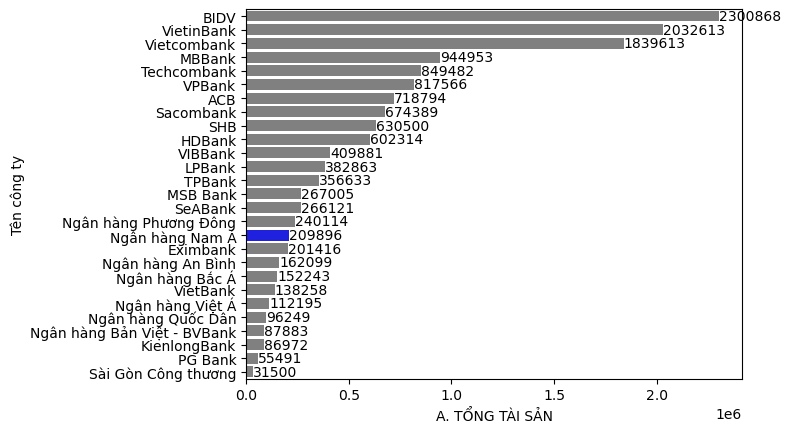

In [9]:
#EDA: ASSET SCALE OF BANKS in 2023
# plotting asset of bank in 2023
bs_sort_asset_2023= data_bs[(data_bs['Quý']=='Hàng năm') & (data_bs['Năm']==2023)].sort_values('A. TỔNG TÀI SẢN',ascending=0)

#set distinctive color for NAB
colors = ['blue' if bank_code == 'NAB' else 'grey' for bank_code in bs_sort_asset_2023['Mã']]

plot_asset=sns.barplot(x='A. TỔNG TÀI SẢN',y='Tên công ty',data=bs_sort_asset_2023,palette=colors)
for i,v in enumerate(bs_sort_asset_2023['A. TỔNG TÀI SẢN'].astype(int)):
    plot_asset.text(v,i,f'{v}',va='center')
plt.show()

In [10]:
# CREATE DIMENSION TABLE FOR BANKS 
dim_bank =data_bs[(data_bs['Quý']=='Hàng năm') & (data_bs['Năm']==2023)][['Mã','Tên công ty']].reset_index(drop=True)
dim_bank=dim_bank.merge(bs_sort_asset_2023[['Mã','Tên công ty','A. TỔNG TÀI SẢN']],on=['Mã','Tên công ty'])

# BASED ON ASSET SCALE, CATEGORIZING BANKS BASED ON ASSET RANGE
# Small: < 100000 tỷ đồng
# Medium: <500000 tỷ đồng
# Big: >= 500000 tỷ đồng
dim_bank['Quy mô theo TS']=  dim_bank['A. TỔNG TÀI SẢN'].apply(lambda x: 'Small' if x<100000 else\
                                                                ('Medium' if x<500000 else 'Big'))
dim_bank['Nhóm big4'] = dim_bank['Mã'].apply(lambda x:'Yes' if x in ('BID','CTG','VCB') else 'No')
dim_bank[dim_bank['Mã']=='NAB']

Criteria,Mã,Tên công ty,A. TỔNG TÀI SẢN,Quy mô theo TS,Nhóm big4
12,NAB,Ngân hàng Nam Á,209896.239,Medium,No


In [11]:
#some banks changed their name over years. Therefore, I use their 2023 names in the dim_bank table
dim_bank[dim_bank['Tên công ty'].str.split().str.len()>1]['Tên công ty'].to_list()
dict ={'Ngân hàng An Bình':'ABBank',
 'Ngân hàng Bắc Á':'Bac A Bank',
 'Ngân hàng Bản Việt - BVBank':'BVBank',
 'MSB Bank':'MSB',
 'Ngân hàng Nam Á':'Nam A Bank',
 'Ngân hàng Quốc Dân':'NCB',
 'Ngân hàng Phương Đông':'OCB',
 'PG Bank':'PG Bank',
 'Sài Gòn Công thương':'Saigonbank',
 'Ngân hàng Việt Á':'VietABank'}
dim_bank['Tên công ty']=dim_bank['Tên công ty'].replace(dict)

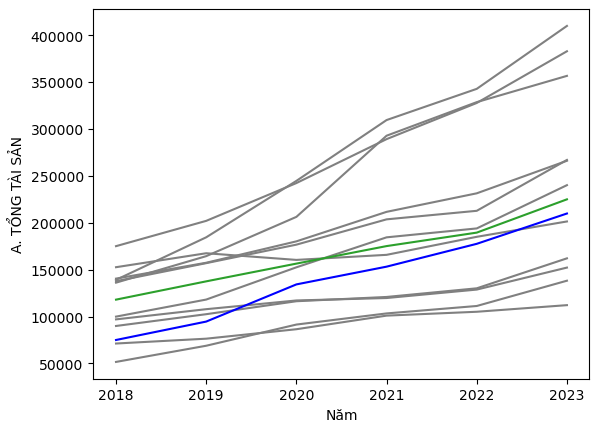

In [12]:
#ASSET GROWTH : (BOR)
data_bs_viz=data_bs.merge(dim_bank,on='Mã',how='left',suffixes=('','_z'))
data_viz=data_bs_viz[(data_bs_viz['Quý']=='Hàng năm')\
                                        &(data_bs_viz['Quy mô theo TS']=='Medium')]
colors = ['blue' if bank_code == 'NAB' else 'grey' for bank_code in data_viz['Mã'].unique()]

sns.lineplot(x='Năm',y='A. TỔNG TÀI SẢN',data =data_viz, hue='Mã', palette=colors,legend=0)
median_assets = data_viz.groupby('Năm')['A. TỔNG TÀI SẢN'].median()  # Get median for each bank, excluding 'Year'
plt.plot(median_assets.index,median_assets)


In [25]:
# Save into CSV
data_bs.to_csv(r'C:\Users\ADMIN\Desktop\Work\portfolio\Bank FS analysis\balance_sheet.csv',index=False,encoding='utf-8-sig')
data_is.to_csv(r'C:\Users\ADMIN\Desktop\Work\portfolio\Bank FS analysis\income_statement.csv',index=False,encoding='utf-8-sig')
dim_bank.to_csv(r'C:\Users\ADMIN\Desktop\Work\portfolio\Bank FS analysis\dim_bank.csv',index=False,encoding='utf-8-sig')
data_fsf.to_csv(r'C:\Users\ADMIN\Desktop\Work\portfolio\Bank FS analysis\fs_footnotes.csv',index=False,encoding='utf-8-sig')